# Data collection and preprocessing

## Load data from hf

In [1]:
from datasets import load_dataset

# load only validation dataset of python
dataset = load_dataset("code_search_net", "python", split="validation")
print(dataset)
# print(dataset[0]['whole_func_string'])
# print(dataset[0]['func_code_string'])
# print(dataset[0]['func_documentation_string'])

/home/uttam/projects/codebert_research/codebert-heads/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 23107
})


## Convert the dataset into pairs of docstring-code

In [2]:
pair_tokens = [(d['func_documentation_tokens'], d['func_code_tokens']) for d in dataset] # type: ignore

# convert tokens back to strings because we have to use roberta tokenizer
pair_tokens = [(" ".join(doc), " ".join(code)) for doc, code in pair_tokens]

# filter out pairs with documentation or code longer than LIMIT
LIMIT = 512
pair_tokens = [pair_token for pair_token in pair_tokens if len(pair_token[0]) <= LIMIT and len(pair_token[1]) <=LIMIT]

len(pair_tokens)

14678

## Cross-encode doc-code pairs using RoBERTa

In [ ]:
from transformers.models.roberta import RobertaTokenizerFast
from tokenizers import processors

tokenizer = RobertaTokenizerFast.from_pretrained("./model/python")
tokenizer._tokenizer.post_processor = processors.BertProcessing(
    sep=("</s>", tokenizer._tokenizer.token_to_id("</s>")),
    cls=("<s>", tokenizer._tokenizer.token_to_id("<s>"))
)

# setting max_length because model expects fixed length inputs
encoded_inputs = tokenizer(pair_tokens[:20], padding="max_length", truncation=True, max_length=256, return_tensors="pt")

In [4]:
sep_indices = [[i for i, token_id in enumerate(encoded_inputs["input_ids"][j]) if token_id == 2] for j in range(len(encoded_inputs["input_ids"]))]
len(sep_indices)

20

In [ ]:
# Init model
from transformers.models.roberta import RobertaModel

# Using roberta because codebert is built on top of it (roberta has the same architecture as bert, the only difference is that it is trained on much more data, and NSP task is skipped while training).
model = RobertaModel.from_pretrained("./model/python", output_attentions=True, attn_implementation="eager")
model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at ./model and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [6]:
import torch
with torch.no_grad():
    outputs = model(**encoded_inputs)

# This is a tuple of (layer1, layer2, ..., layer12), each shape: [1, num_heads, seq_len, seq_len]
# attentions[layer][batch][head] -> 2d array representing attention scores
print(outputs.attentions[0][0][0].shape) # attention scores of first attention head in first layer of first sequence

torch.Size([256, 256])


# Analysis

## Entropy

In [7]:
def get_entropy(attention_matrix):
    """
    Calculate the entropy of the attention matrix.
    """
    flatention_matrix = attention_matrix.flatten()
    prob = flatention_matrix / (flatention_matrix.sum() + 1e-10)  # Adding a small value to avoid division by zero
    entropy = -torch.sum(prob * torch.log(prob + 1e-10))  # Adding a small value to avoid log(0)
    return entropy.item()

In [8]:
e = get_entropy(outputs.attentions[0][0][0])  # Entropy of the first attention head in the first layer of the first sequence
e

7.532896995544434

## Sparsity

In [9]:
def get_sparsity(attention_matrix, threshold=0.01):
    """
    Calculate the sparsity of the attention matrix.
    """
    flatention_matrix = attention_matrix.flatten()
    insignificant_sum = (flatention_matrix < threshold).sum().item()
    return insignificant_sum / len(flatention_matrix)

In [10]:
s = get_sparsity(outputs.attentions[0][0][1])  # Sparsity of the first attention head in the first layer of the first sequence
s

0.89617919921875

## Standard deviation

In [11]:
def get_std(attention_matrix):
    """
    Calculate the standard deviation of the attention matrix.
    """
    flatention_matrix = attention_matrix.flatten()
    return flatention_matrix.std().item()

In [12]:
std = get_std(outputs.attentions[0][0][2])  # Standard deviation of the first attention head in the first layer of the first sequence
std

0.005437016487121582

## Maximum

In [13]:
def get_max(attention_matrix):
    """
    Calculate the maximum value of the attention matrix.
    """
    flatention_matrix = attention_matrix.flatten()
    return flatention_matrix.max().item()

In [14]:
ma = get_max(outputs.attentions[0][0][3])  # Maximum value of the first attention head in the first layer of the first sequence
ma

0.10337016731500626

## Compute cross model attention

In [15]:
def cross_model_attn(attention_matrix, sep_indices: list[int]):
    """
    Calculate the cross-model attention for a given attention head.
    """
    query_start = 1
    query_end = sep_indices[0]
    code_start = sep_indices[0] + 1
    code_end = sep_indices[1]
    query_to_code = attention_matrix[query_start:query_end, code_start:code_end].mean()
    code_to_query = attention_matrix[code_start:code_end, query_start:query_end].mean()
    code_to_code = attention_matrix[code_start:code_end, code_start:code_end].mean()
    query_to_query = attention_matrix[query_start:query_end, query_start:query_end].mean()

    return {
        "query_to_code": query_to_code,
        "code_to_query": code_to_query,
        "code_to_code": code_to_code,
        "query_to_query": query_to_query
    }

In [16]:
c = cross_model_attn(outputs.attentions[10][0][9], sep_indices[0])  
c

{'query_to_code': tensor(0.0002),
 'code_to_query': tensor(0.0010),
 'code_to_code': tensor(0.0041),
 'query_to_query': tensor(0.0190)}

## Aggregate

In [17]:
def analyze_attention(attention_data, sep_indices):
    """
    Analyze all the attention heads in all layers and all batches and return a dictionary with entropy, sparsity, and cross-model attention.
    """
    results = {}
    for i, layer in enumerate(attention_data):
        results[f"layer_{i}"] = {}
        for j, batch in enumerate(layer):
            if f"batch_{j}" not in results[f"layer_{i}"]:
                results[f"layer_{i}"][f"batch_{j}"] = {}
            for k, attention_head in enumerate(batch):
                if f"head_{k}" not in results[f"layer_{i}"][f"batch_{j}"]:
                    results[f"layer_{i}"][f"batch_{j}"][f"head_{k}"] = {}

                # Calculate metrics
                results[f"layer_{i}"][f"batch_{j}"][f"head_{k}"]["entropy"] = get_entropy(attention_head)
                results[f"layer_{i}"][f"batch_{j}"][f"head_{k}"]["sparsity"] = get_sparsity(attention_head)
                results[f"layer_{i}"][f"batch_{j}"][f"head_{k}"]["std"] = get_std(attention_head)
                results[f"layer_{i}"][f"batch_{j}"][f"head_{k}"]["max"] = get_max(attention_head)
                results[f"layer_{i}"][f"batch_{j}"][f"head_{k}"]["cross_model_attn"] = cross_model_attn(attention_head, sep_indices[j])
    return results

In [18]:
res = analyze_attention(outputs.attentions, sep_indices)

In [19]:
import numpy as np

attention_data = outputs.attentions  
num_layers = len(attention_data)
num_heads = attention_data[0].shape[1]  # shape: [batch_size, num_heads, seq_len, seq_len]

entropy_matrix = np.zeros((num_layers, num_heads))
sparsity_matrix = np.zeros((num_layers, num_heads))
std_matrix = np.zeros((num_layers, num_heads))
max_matrix = np.zeros((num_layers, num_heads))
q2c_matrix = np.zeros((num_layers, num_heads))
c2q_matrix = np.zeros((num_layers, num_heads))
c2c_matrix = np.zeros((num_layers, num_heads))
q2q_matrix = np.zeros((num_layers, num_heads))

for i in range(num_layers):
    for k in range(num_heads):
        entropy_vals, sparsity_vals, std_vals, max_vals, q2c_vals, c2q_vals, c2c_vals, q2q_vals = [], [], [], [], [], [], [], []
        for j in range(attention_data[0].shape[0]):  # batch_size
            head_data = res[f"layer_{i}"][f"batch_{j}"][f"head_{k}"]
            entropy_vals.append(head_data["entropy"])
            sparsity_vals.append(head_data["sparsity"])
            std_vals.append(head_data["std"])
            max_vals.append(head_data["max"])
            q2c_vals.append(head_data["cross_model_attn"]["query_to_code"])
            c2q_vals.append(head_data["cross_model_attn"]["code_to_query"])
            c2c_vals.append(head_data["cross_model_attn"]["code_to_code"])
            q2q_vals.append(head_data["cross_model_attn"]["query_to_query"])

        entropy_matrix[i, k] = np.mean(entropy_vals)
        sparsity_matrix[i, k] = np.mean(sparsity_vals)
        std_matrix[i, k] = np.mean(std_vals)
        max_matrix[i, k] = np.mean(max_vals)
        q2c_matrix[i, k] = np.mean(q2c_vals)
        c2q_matrix[i, k] = np.mean(c2q_vals)
        c2c_matrix[i, k] = np.mean(c2c_vals)
        q2q_matrix[i, k] = np.mean(q2q_vals)

# Visualize

## Entropy

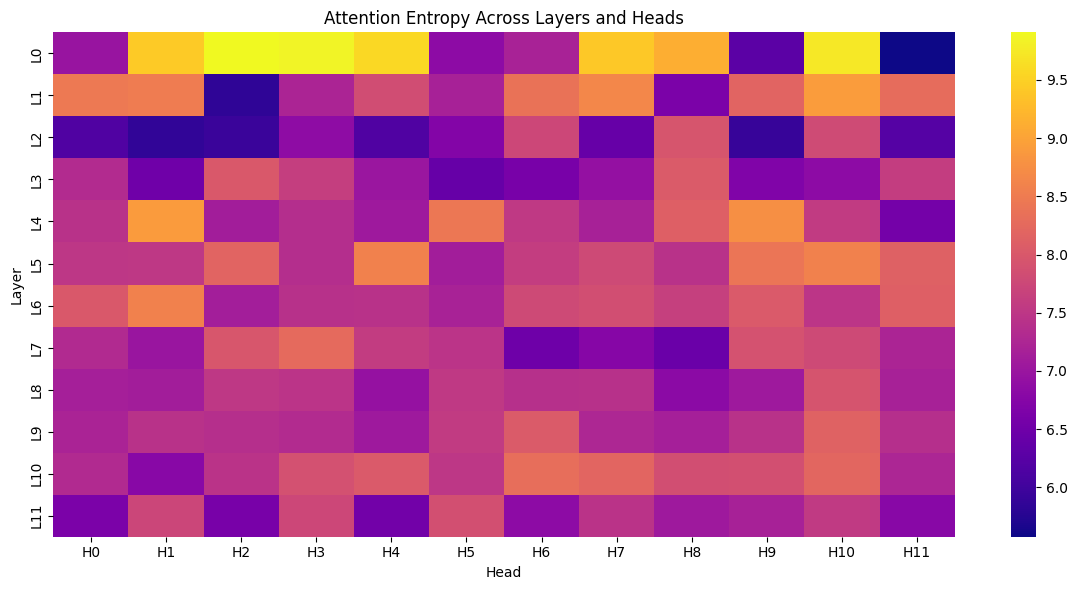

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(entropy_matrix, annot=False, cmap="plasma", xticklabels=[f"H{i}" for i in range(num_heads)],
            yticklabels=[f"L{i}" for i in range(num_layers)])
plt.title("Attention Entropy Across Layers and Heads")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()


## Sparsity

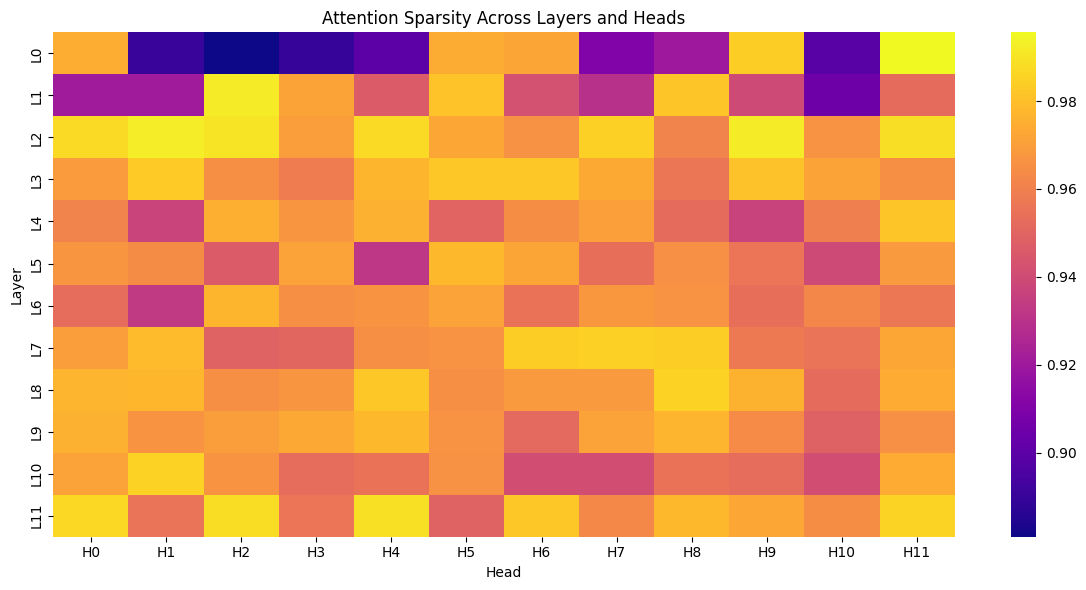

In [21]:
plt.figure(figsize=(12, 6))
sns.heatmap(sparsity_matrix, annot=False, cmap="plasma", xticklabels=[f"H{i}" for i in range(num_heads)],
            yticklabels=[f"L{i}" for i in range(num_layers)])
plt.title("Attention Sparsity Across Layers and Heads")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

## Standard deviation

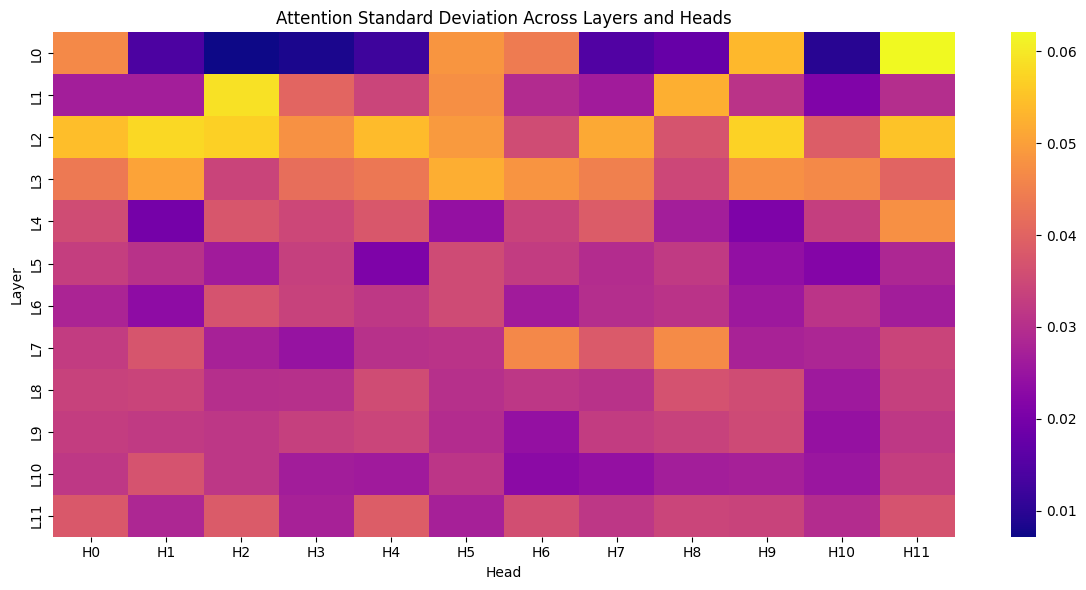

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(std_matrix, annot=False, cmap="plasma", xticklabels=[f"H{i}" for i in range(num_heads)],
            yticklabels=[f"L{i}" for i in range(num_layers)])
plt.title("Attention Standard Deviation Across Layers and Heads")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

## Maximum

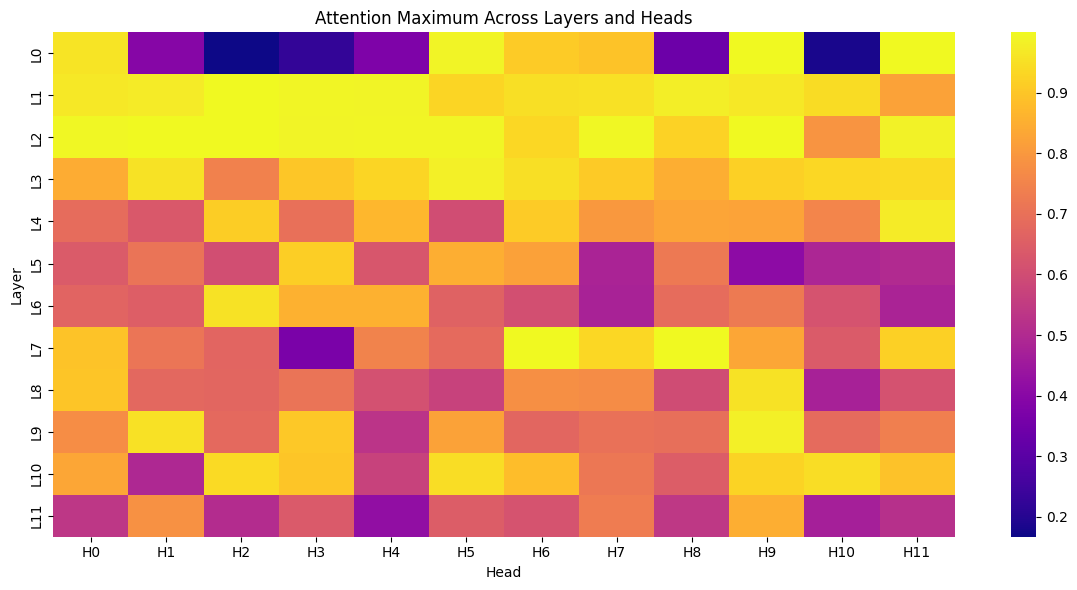

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(max_matrix, annot=False, cmap="plasma", xticklabels=[f"H{i}" for i in range(num_heads)],
            yticklabels=[f"L{i}" for i in range(num_layers)])
plt.title("Attention Maximum Across Layers and Heads")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

## Cross attention

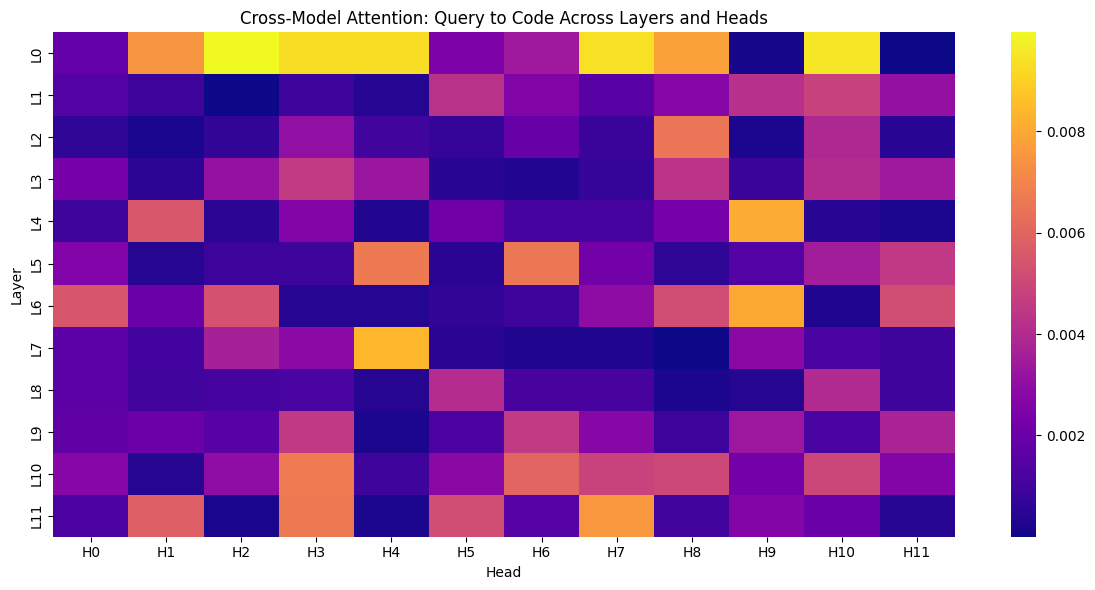

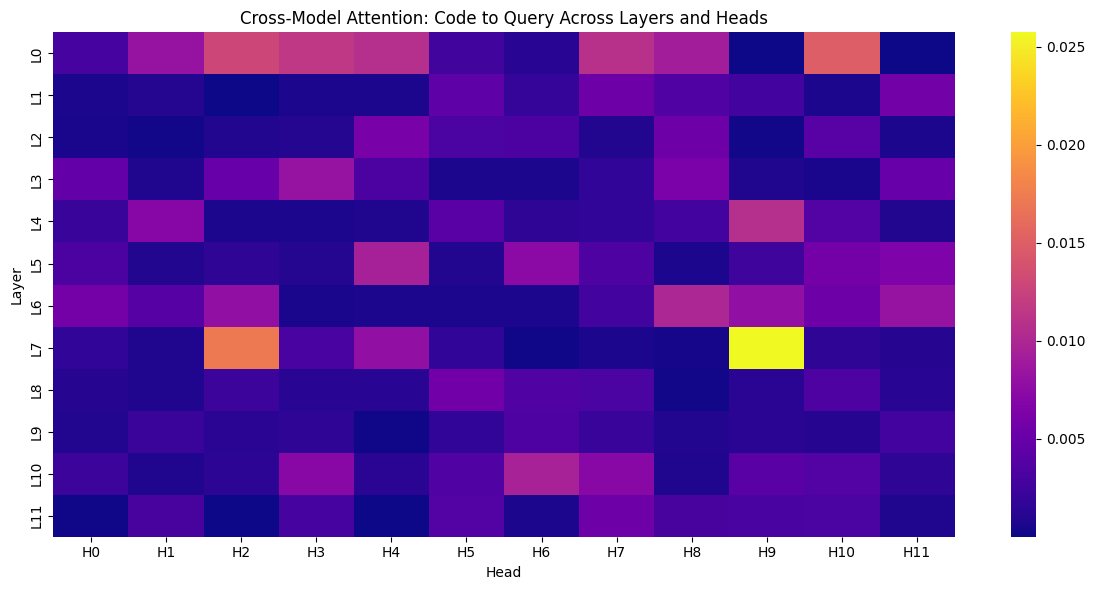

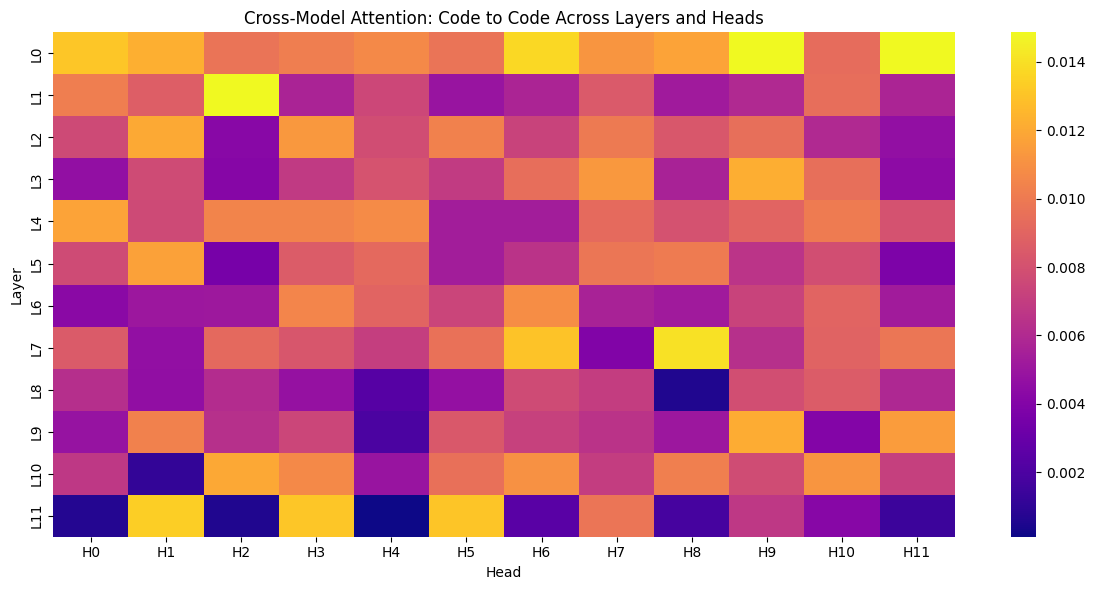

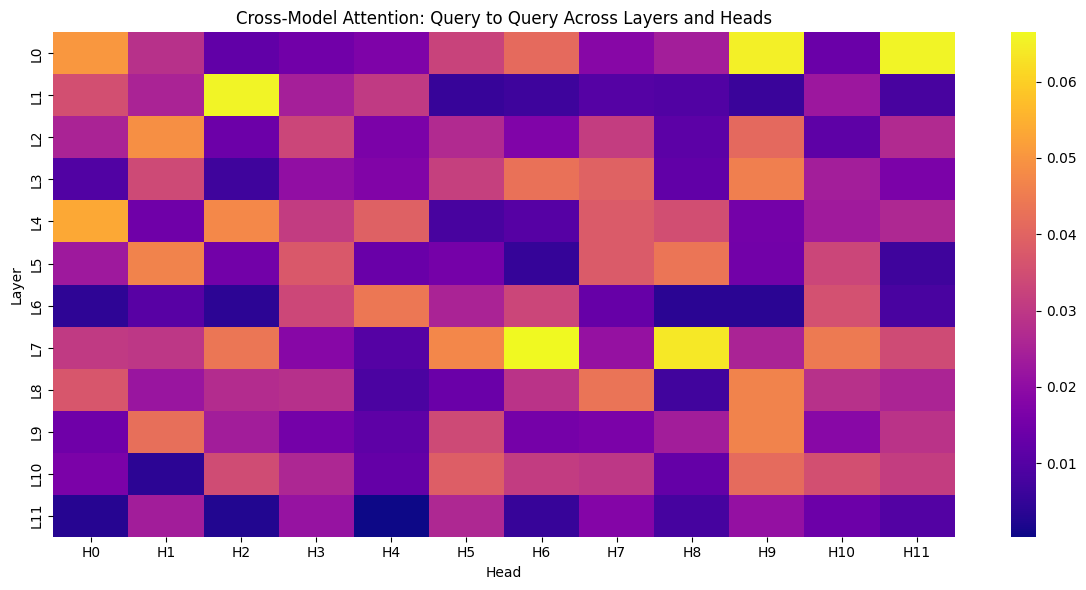

In [24]:
x = [q2c_matrix, c2q_matrix, c2c_matrix, q2q_matrix]
titles = ["Query to Code", "Code to Query", "Code to Code", "Query to Query"]
for i, matrix in enumerate(x):
    plt.figure(figsize=(12, 6))
    sns.heatmap(matrix, annot=False, cmap="plasma", xticklabels=[f"H{i}" for i in range(num_heads)],
                yticklabels=[f"L{i}" for i in range(num_layers)])
    plt.title(f"Cross-Model Attention: {titles[i]} Across Layers and Heads")
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()